### Meandering demo overview

Anchors:
- `analog_image_generator.geologic_generators.generate_meandering`
- `analog_image_generator.stacked_channels.build_stacked_fluvial`
- `analog_image_generator.stats.compute_metrics`
- `analog_image_generator.reporting.build_reports`

Use this notebook to demonstrate the features listed below. Fill in the upcoming sections (presets, generator runs, stacked packages, metrics, reporting, and debugging hooks) before the professor review.


# Fluvial Meandering Anchors
Traceability notebook for the meandering functions implemented in `src/analog_image_generator/geologic_generators.py`.

#### Demo checklist

- [ ] Parameter presets referencing `_MEANDER_DEFAULTS`
- [ ] Single-belt generator run cell (grayscale + masks)
- [ ] Stacked package run cell with relief/metadata display
- [ ] Visualization panel (gray, color, package_id map, legend)
- [ ] Metrics summary using `stats.compute_metrics`
- [ ] Reporting hook (CSV/PDF snippet or smoke link)
- [ ] Debug controls for seed/package toggles + Task Master notes


In [1]:
from analog_image_generator import geologic_generators as gg

MEANDER_BASELINE = {
    "style": "meandering",
    "height": 256,
    "width": 256,
    "seed": 42,
    "n_control_points": gg._MEANDER_DEFAULTS["n_control_points"],
    "amplitude_range": gg._MEANDER_DEFAULTS["amplitude_range"],
    "drift_fraction": gg._MEANDER_DEFAULTS["drift_fraction"],
    "channel_width_min": gg._MEANDER_DEFAULTS["channel_width_min"],
    "channel_width_max": gg._MEANDER_DEFAULTS["channel_width_max"],
}

HIGH_SINUOSITY = {
    **MEANDER_BASELINE,
    "amplitude_range": (0.25, 0.35),
    "drift_fraction": 0.15,
}

STACKED_POINTBAR_SWEEP = {
    **MEANDER_BASELINE,
    "mode": "stacked",
    "package_count": 2,
    "package_styles": ["meandering", "braided"],
    "package_relief_px": 18,
    "package_erosion_depth_px": 12,
}

MEANDER_PRESETS = {
    "baseline": MEANDER_BASELINE,
    "high_sinuosity": HIGH_SINUOSITY,
    "stacked_pointbar_sweep": STACKED_POINTBAR_SWEEP,
}
MEANDER_PRESETS

{'baseline': {'style': 'meandering',
  'height': 256,
  'width': 256,
  'seed': 42,
  'n_control_points': 6,
  'amplitude_range': (0.08, 0.22),
  'drift_fraction': 0.08,
  'channel_width_min': 26.0,
  'channel_width_max': 46.0},
 'high_sinuosity': {'style': 'meandering',
  'height': 256,
  'width': 256,
  'seed': 42,
  'n_control_points': 6,
  'amplitude_range': (0.25, 0.35),
  'drift_fraction': 0.15,
  'channel_width_min': 26.0,
  'channel_width_max': 46.0},
 'stacked_pointbar_sweep': {'style': 'meandering',
  'height': 256,
  'width': 256,
  'seed': 42,
  'n_control_points': 6,
  'amplitude_range': (0.08, 0.22),
  'drift_fraction': 0.08,
  'channel_width_min': 26.0,
  'channel_width_max': 46.0,
  'mode': 'stacked',
  'package_count': 2,
  'package_styles': ['meandering', 'braided'],
  'package_relief_px': 18,
  'package_erosion_depth_px': 12}}

In [2]:
from analog_image_generator import geologic_generators as gg
from analog_image_generator import stacked_channels as sc

def run_single_meander(params: dict) -> tuple:
    config = {**MEANDER_PRESETS['baseline'], **params}
    analog, masks = gg.generate_fluvial(config)
    return analog, masks

def run_stacked_meander(params: dict) -> tuple:
    config = {**MEANDER_PRESETS['stacked_pointbar_sweep'], **params}
    analog, masks = sc.build_stacked_fluvial(config)
    return analog, masks

single_meander = run_single_meander({})
stacked_meander = run_stacked_meander({})
single_meander[0].shape, stacked_meander[0].shape

((256, 256), (256, 256))

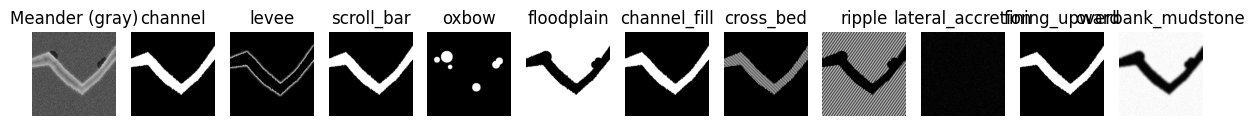

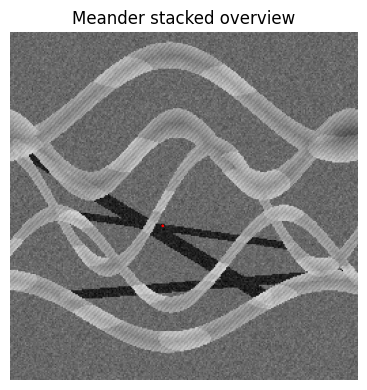

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def _mask_arrays(masks_dict):
    arrays = []
    for name, value in masks_dict.items():
        if isinstance(value, np.ndarray) and value.ndim >= 2:
            arrays.append((name, value.astype(np.float32)))
    return arrays

def _plot_masks(analog, masks_dict, title: str):
    arrays = _mask_arrays(masks_dict)
    fig, axes = plt.subplots(1, len(arrays) + 1, figsize=(12, 4))
    axes[0].imshow(analog, cmap='gray', vmin=0.0, vmax=1.0)
    axes[0].set_title(f"Meander (gray)")
    axes[0].axis('off')
    for ax, (name, mask) in zip(axes[1:], arrays):
        ax.imshow(mask, cmap='gray', vmin=0.0, vmax=1.0)
        ax.set_title(name)
        ax.axis('off')
    fig.tight_layout()

analog_single, masks_single = single_meander
_plot_masks(analog_single, masks_single, 'Meander single run')

analog_stacked, masks_stacked = stacked_meander
fig = plt.figure(figsize=(6, 4))
plt.imshow(analog_stacked, cmap='gray', vmin=0.0, vmax=1.0)
package_map = masks_stacked.get('package_id_map')
if isinstance(package_map, np.ndarray) and package_map.ndim >= 2:
    plt.contour(package_map, levels=6, colors='r', linewidths=0.4)
plt.title('Meander stacked overview')
plt.axis('off')
fig.tight_layout()

## anchor-fluvial-meander-centerline
`meander_centerline(H, W, n_ctrl, amp_range, drift_frac, rng)` builds a sinuosity-aware centerline using control points and stochastic drift.

## anchor-fluvial-variable-width
`meander_variable_channel(centerline, shape, w0, w1, rng)` widens/narrows the belt along strike before rasterization.

## anchor-fluvial-levees
`add_levees(chan, iterations)` dilates channel banks and applies a gaussian rim to emulate levees.

## anchor-fluvial-scroll-bars
`add_scroll_bars(chan, lambda_px)` converts EDT bands into cosine scroll textures.

## anchor-fluvial-oxbow
`add_oxbow(centerline, shape, neck_tol, rng)` seeds oxbow scars based on centerline samples.

## anchor-fluvial-compose
`compose_meandering(gray, masks, noise_scale, rng)` normalizes grayscale output and ensures mask metadata stays consistent.

## anchor-fluvial-generate
`generate_meandering(params, rng)` orchestrates the centerline, channel raster, levees, scroll bars, oxbows, and composition before returning `(gray, masks)`.

## anchor-sedimentary-approximations
Sedimentary overlays in this notebook use simplified distance-to-mask gradients, Gaussian-smoothed noise, and deterministic laminae frequencies (no fully resolved laminae or grain-scale physics). Mineralogy percentages are constrained heuristics (`feldspar`, `quartz`, `clay`) summing to 1.0; cement signatures toggle between kaolinite/calcite based on marsh coverage, and mud_clasts_bool reflects overbank fraction. These approximations target qualitative realism for previews/statistics rather than exact petrophysical fidelity.


### anchor-fluvial-stacked-packages

Stacked channel workflows toggle via `params["mode"] = "stacked"`, which calls `analog_image_generator.stacked_channels.build_stacked_fluvial` to mix meandering/braided/anasto packages. 
Sliders feed `package_count`, style lists, and per-package thickness/relief knobs so GEOLOGIC_RULES stays traceable. 
Boundary masks (`upper_surface_mask`, `erosion_surface_mask`, `package_id_map`) and stack metadata propagate to stats/reporting through `masks["realization_metadata"]["stacked_packages"]`.

### anchor-fluvial-compose

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-generate

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-levees

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-meander-centerline

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-oxbow

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-scroll-bars

Automated anchor placeholder for GEOLOGIC_RULES mapping.

### anchor-fluvial-variable-width

Automated anchor placeholder for GEOLOGIC_RULES mapping.